<a href="https://colab.research.google.com/github/Dandhalf/Practice/blob/main/tensorflow_05_COVID_19_Radiography_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Kaggle COVID 19 Radiography
- Viral Pneumonia, Lung Opacity(폐색증), Normal 등 발견하고 예측 위함
- 총 21165개 chest X-Ray 이미지 데이터

In [3]:
# colab에 mydrive 마운트
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# colab으로 copy
import shutil
import os

try : 
  dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/dataset'

  shutil.copy(os.path.join(dataset_path, 'COVID_19_radiography.zip'), '/content')

except Exception as err:
  print(str(err))

In [5]:
import os
ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'COVID_19_radiography')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [6]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
  shutil.rmtree(DATA_ROOT_DIR)
  print(DATA_ROOT_DIR + ' is removed!!!')


In [7]:
# 압축풀기
import zipfile
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'COVID_19_radiography.zip'), 'r') as target_file:

  target_file.extractall(DATA_ROOT_DIR)


## 데이터 전처리 | train 디렉토리 생성 및 데이터 구축

In [8]:
import shutil
import os
import glob

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset/*'))

# list comprehension 이용해 COVID, Lung Opacity, Normal, Viral Pnemonia 등의 정답 리스트 생성
label_name_list = [file_name.split('/')[-1].strip() 
                  for file_name in total_file_list 
                  if os.path.isdir(file_name) == True]

# 각각의 정답(label)에 대해서
for label_name in label_name_list:

  src_dir_path = os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset' + '/' + label_name + '/images')
  
  dst_dir_path = os.path.join(DATA_ROOT_DIR, 'train' + '/' + label_name)

  try:
    # shutil.copytree 이용해서 원본 데이터와 동일한 정답을 가지는 train 디렉토리를 생성하고 원본 이미지 복사
    shutil.copytree(src_dir_path, dst_dir_path)
  except Exception as err:
    print(str(err))

if not os.path.exists(TEST_DATA_ROOT_DIR):
  os.mkdir(TEST_DATA_ROOT_DIR) # 원본데이터와 동일한 정답을 가지는 test 디렉토리 생성

for label_name in label_name_list:
   # 원본데이터와 동일한 정답을 가지는 test 디렉토리 생성

    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
      os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))


In [9]:
import random

# TRAIN : TEST = 80:20
MOVE_RATIO = 0.2

# 파일 move train_data_dir => test_data_dir

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

# train 디렉토리 각각의 label(정답)에 대해서
for label_name in label_name_list:

  # 파일 move 위하기 위한 src_dir_path, dst_dir_path 설정
  src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

  # label 디렉토리에 있는 이미지 파일 목록을 뽑아냄
  train_data_file_list = os.listdir(src_dir_path)

  # 데이터 다양성 위해 train data를 random하게 shuffle한 후에
  random.shuffle(train_data_file_list)
  split_num = int(MOVE_RATIO*len(train_data_file_list))
  test_data_file_list = train_data_file_list[0:split_num]

  for test_data_file in test_data_file_list:

      try:
        # train 디렉토리에서 20% 비율로 test 디렉토리로 move
          shutil.move(os.path.join(src_dir_path, test_data_file),
                      os.path.join(dst_dir_path, test_data_file ))
      except Exception as err:
            print(str(err))

In [10]:
label_name_list

['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

### ImageDataGenerator 생성

In [11]:
# train 데이터로부터 20% 비율로 validation data 생성
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
validation_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32,
                                                    color_mode = 'rgb', class_mode = 'sparse',
                                                    target_size = (IMG_WIDTH,IMG_HEIGHT),
                                                    subset = 'training')

validation_generator = validation_data_gen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size = 32,
                                                        color_mode = 'rgb', class_mode = 'sparse',
                                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                                        subset = 'validation')

test_generator = train_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size = 32,
                                                    color_mode = 'rgb', class_mode = 'sparse',
                                                    target_size = (IMG_WIDTH,IMG_HEIGHT),
                                                    subset = 'training')

Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 3388 images belonging to 4 classes.


In [13]:
print(train_generator.class_indices, train_generator.num_classes)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3} 4


### ImageDataGenerator 이용한 학습 데이터 확인

In [14]:
IMG_NUMS = 16

image_data, label_data = train_generator.next()

# ImageDataGenerator로 랜덤하게 생성된 32개 이미지와 정답에서 16개 선택
data = image_data[:IMG_NUMS]
label = label_data[:IMG_NUMS]


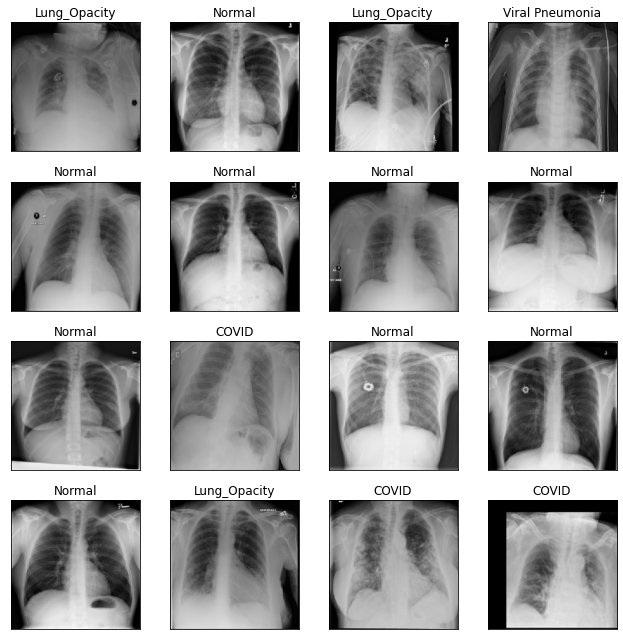

In [15]:
import matplotlib.pyplot as plt

class_dict = {0 :'COVID', 1:'Lung_Opacity', 2:'Normal', 3: 'Viral Pneumonia'}

plt.figure(figsize = (9,9))

for i in range(len(label)):

  plt.subplot(4,4, i+1)
  plt.title(str(class_dict[label[i]]))
  plt.xticks([]);  plt.yticks([])

  plt.imshow(data[i])

plt.tight_layout()
plt.show()

## 모델 구축

In [16]:
from tensorflow.keras.applications import MobileNet

class_nums = train_generator.num_classes

pre_trained_model = MobileNet(weights = 'imagenet', include_top = False, input_shape = (IMG_WIDTH,IMG_HEIGHT,3))

model = keras.models.Sequential()

model.add(pre_trained_model)
model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(class_nums, activation = 'softmax'))

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                         

In [17]:
# 모델 컴파일
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(2e-5), metrics = ['accuracy'])

from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
save_file_name = './COVID-19_Radiography_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor = 'val_loss', verbose = 1, 
                            save_best_only = True, mode = 'auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience = 5)

hist = model.fit(train_generator, epochs = 20, validation_data = validation_generator, callbacks = [checkpoint, earlystopping])

Epoch 1/20
424/424 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.7130
Epoch 1: val_loss improved from inf to 0.40328, saving model to ./COVID-19_Radiography_MobileNet_Colab.h5
424/424 [==============================] - 106s 216ms/step - loss: 0.7532 - accuracy: 0.7130 - val_loss: 0.4033 - val_accuracy: 0.8567
Epoch 2/20
424/424 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8697
Epoch 2: val_loss improved from 0.40328 to 0.23799, saving model to ./COVID-19_Radiography_MobileNet_Colab.h5
424/424 [==============================] - 92s 216ms/step - loss: 0.3813 - accuracy: 0.8697 - val_loss: 0.2380 - val_accuracy: 0.9182
Epoch 3/20
424/424 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9038
Epoch 3: val_loss improved from 0.23799 to 0.22230, saving model to ./COVID-19_Radiography_MobileNet_Colab.h5
424/424 [==============================] - 92s 217ms/step - loss: 0.2793 - accuracy: 0.9038 - val_loss: 0.2223 - val_

### 손실 및 정확도

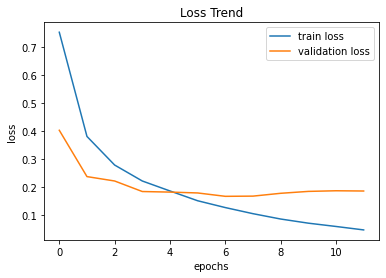

In [18]:
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid

plt.plot(hist.history['loss'], label = 'train loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')

plt.legend(loc = 'best')

plt.show()


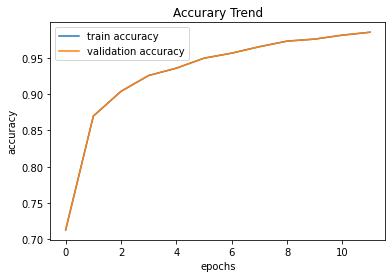

In [19]:
plt.title('Accurary Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid

plt.plot(hist.history['accuracy'], label = 'train accuracy')
plt.plot(hist.history['accuracy'], label = 'validation accuracy')

plt.legend(loc = 'best')

plt.show()

## 테스트

In [24]:
pred = model.predict(test_generator)
print(pred.shape)

(3388, 4)


In [41]:
np.argmax(pred[0:16], axis = 1)

array([1, 0, 2, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 1, 2])

In [ ]:
IMG_NUMS = 16

image_data, label_data = test_generator.next()

# ImageDataGenerator로 생성된 32개 이미지와 정답에서 16개 선택
data = image_data[:IMG_NUMS]
label = label_data[:IMG_NUMS]

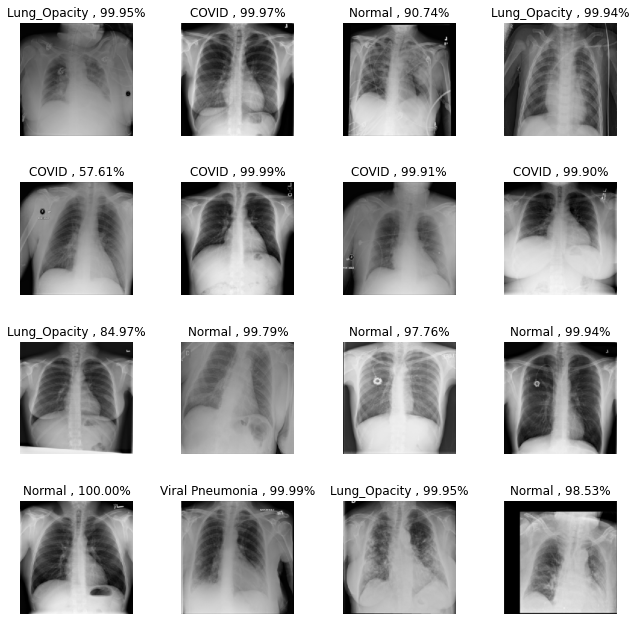

In [35]:
import matplotlib.pyplot as plt
import numpy as np

class_dict = {0 :'COVID', 1:'Lung_Opacity', 2:'Normal', 3: 'Viral Pneumonia'}

plt.figure(figsize = (9,9))

# 예측한 것 중 16개만 가져오려고함 
for i in range(len(data)):
  plt.subplot(4,4, i+1)

  prediction = str(class_dict[np.argmax(pred[i])])
  proba = '{0:0.2f}'.format(100*max(pred[i]))
  title_str = prediction + ' , ' + proba + '%'

  plt.axis('off')
  plt.title(title_str)
  plt.xticks([]);  plt.yticks([])
  plt.imshow(data[i])

plt.tight_layout()
plt.show()